# Predicting Metascore and Star-rating 

In [0]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df_movies = pd.read_csv("/content/drive/My Drive/DATA 301/movies.csv")

In [0]:
df_no_na = df_movies.dropna()
df_no_na.head(5)

,Unnamed: 0,types,title,year,rating,runtime,genre,star-rating,metascore,description,director,cast,votes,gross
0,0,good,The Shawshank Redemption,1994,R,142,Drama,9.3,80.0,Two imprisoned men bond over a number of y...,Frank Darabont,Tim Robbins Morgan Freeman Bob Gunton William ...,2200614,4.608596e+07
1,1,good,The Godfather,1972,R,175,"Crime,Drama",9.2,100.0,The aging patriarch of an organized crime ...,Francis Ford Coppola,Marlon Brando Al Pacino James Caan Diane Keaton,1516232,7.763191e+08
2,2,good,The Dark Knight,2008,PG-13,152,"Action,Crime,Drama",9.0,84.0,When the menace known as the Joker wreaks ...,Christopher Nolan,Christian Bale Heath Ledger Aaron Eckhart Mich...,2182194,5.987053e+08
3,3,good,The Godfather: Part II,1974,R,202,"Crime,Drama",9.0,90.0,The early life and career of Vito Corleone...,Francis Ford Coppola,Al Pacino Robert De Niro Robert Duvall Diane K...,1062195,2.801075e+08
4,4,good,Pulp Fiction,1994,R,154,"Crime,Drama",8.9,94.0,"The lives of two mob hitmen, a boxer, a ga...",Quentin Tarantino,John Travolta Uma Thurman Samuel L. Jackson Br...,1729327,1.755137e+08


This is a pretty standardized error score method used for tuning the parameters of our pipelines a little bit better. This is used for things like proper scaling and metrics in KNearest, but used for finding the best feature sets in all of the other models, except the StackingRegressor model.
This method returns the RMSE of the pipeline given on the feature set for the target variable y. 

In [0]:
def get_cv_error(feature_set, pipeline, y):
  cv_errs = -cross_val_score(pipeline, X = df_no_na[feature_set],
                         y = df_no_na[y],
                         scoring = "neg_mean_squared_error", cv = 10)
  return np.sqrt(cv_errs.mean())

The process for determing feature sets is the same across all of our models with the exception of the Stacking Regressor. The process is pretty straightforward, pick a group of features that we think might be good candidates, look at the RMSE for the each feature set, choose the one with the lowest score, then hyper-parameter tune with GridSearchCV, then find its RMSE. 

In [0]:
ct_1 = make_column_transformer(
    (StandardScaler(), ["votes"]),
    (TfidfVectorizer(norm = None, max_features = 100),"director"),
    (TfidfVectorizer(norm = None, max_features = 100), "cast"),
    remainder = "drop"
)
ct_2 = make_column_transformer(
    (StandardScaler(), ["votes", "year"]),
    (TfidfVectorizer(norm = None, max_features = 100), "description"),
    remainder = "drop"
)
ct_3 = make_column_transformer(
    (StandardScaler(), ["votes"]),
    (TfidfVectorizer(norm = None, max_features = 100),"director"),
    remainder = "drop"
)
ct_4 = make_column_transformer(
    (TfidfVectorizer(norm = None, max_features = 100), "description","director"),
    (TfidfVectorizer(norm = None, max_features = 100), "cast"),
    (OneHotEncoder(handle_unknown = "ignore"), ["rating","year"]),
    remainder = "drop"
)
ct_5 = make_column_transformer(
    (StandardScaler(), ["votes"]),
    (OneHotEncoder(handle_unknown = "ignore"), ["year"]),
    remainder = "drop"
)
ct_6 = make_column_transformer(
    (OneHotEncoder(handle_unknown = "ignore"), ["cast"]),
    remainder = "drop"
)
features = []
features.append((["votes","director","cast"], ct_1))
features.append((["votes","year","description"], ct_2))
features.append((["votes","director"], ct_3))
features.append((["year","description","director","cast","rating"], ct_4))
features.append((["cast"], ct_6))

For the rest of this notebook, I will be referring critic score as metascore and user score as star-rating.    

### Linear Regression

We chose the basic Linear Regression model because we thought it would be a good baseline score for comparing to KNearest and Lasso.

For predicting metascore:

In [0]:
errs = pd.Series()
for item in features:
  pipeline = make_pipeline(
      item[1],
      LinearRegression()
  )
  errs[str(item[0])] = get_cv_error(item[0], pipeline, "metascore")
errs

['votes', 'director', 'cast']                            26.140410
['votes', 'year', 'description']                         16.972168
['votes', 'director']                                    23.785556
['year', 'description', 'director', 'cast', 'rating']    21.334757
['cast']                                                 26.832140
dtype: float64

For predicting star-rating:

In [0]:
errs = pd.Series()
for item in features:
  pipeline = make_pipeline(
      item[1],
      LinearRegression()
  )
  errs[str(item[0])] = get_cv_error(item[0], pipeline, "star-rating")
errs

['votes', 'director', 'cast']                            1.772289
['votes', 'year', 'description']                         0.827750
['votes', 'director']                                    1.598924
['year', 'description', 'director', 'cast', 'rating']    1.219480
['cast']                                                 1.925090
dtype: float64

In the case of the basic linear regression model, the feature set that best predicts scores for both metascore and star-rating is votes, year, and description. We only chose over the feature set as the linear model did not have any other metrics to fit, other than possibly its degree which we had a problem implementing.

The star-rating score was much lower than metascore with its RMSE being 0.827, whereas the metascore was much higher with its RMSE being 16.972. I believe that these scores were pretty good considering it was with base Linear Regression and will be a good benchmark for comparing the performance of both KNearest and Lasso models.

### KNearest Neighbors

We chose KNearest as it is not a linear model and uses the neighboring points for prediction. 

For predicting metascore:

In [0]:
errs = pd.Series()
for item in features:
  pipeline = make_pipeline(
      item[1],
      KNeighborsRegressor(n_neighbors = 20)
  )
  errs[str(item[0])] = get_cv_error(item[0], pipeline, "metascore")
errs

['votes', 'director', 'cast']                            21.897392
['votes', 'year', 'description']                         19.167121
['votes', 'director']                                    18.260756
['year', 'description', 'director', 'cast', 'rating']    21.612831
['cast']                                                 25.111983
dtype: float64

In [0]:
pipelines = [
             make_pipeline(make_column_transformer(
              (StandardScaler(), ["votes"]),
              (TfidfVectorizer(norm = None, max_features = 100),"director"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "euclidean")),
             make_pipeline(make_column_transformer(
              (StandardScaler(), ["votes"]),
              (TfidfVectorizer(norm = None, max_features = 100),"director"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "manhattan")),
             make_pipeline(make_column_transformer(
              (StandardScaler(), ["votes"]),
              (TfidfVectorizer(norm = None, max_features = 100),"director"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "minkowski")),
             make_pipeline(make_column_transformer(
              (Normalizer(), ["votes"]),
              (TfidfVectorizer(norm = None, max_features = 100),"director"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "minkowski")),
             make_pipeline(make_column_transformer(
              (Normalizer(), ["votes"]),
              (TfidfVectorizer(norm = None, max_features = 100),"director"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "euclidean")),
             make_pipeline(make_column_transformer(
              (Normalizer(), ["votes"]),
              (TfidfVectorizer(norm = None, max_features = 100),"director"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "manhattan")),
             make_pipeline(make_column_transformer(
              (MinMaxScaler(), ["votes"]),
              (TfidfVectorizer(norm = None, max_features = 100),"director"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "minkowski")),
             make_pipeline(make_column_transformer(
              (MinMaxScaler(), ["votes"]),
              (TfidfVectorizer(norm = None, max_features = 100),"director"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "euclidean")),
             make_pipeline(make_column_transformer(
              (MinMaxScaler(), ["votes"]),
              (TfidfVectorizer(norm = None, max_features = 100),"director"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "manhattan"))
             ]
best_combos = pd.Series()
index = 0

for pipeline in pipelines:
  best_combos[str(index)] = get_cv_error(["votes", "director"] , pipeline, "metascore")
  index += 1
best_combos

0    18.260756
1    18.351726
2    18.260756
3    31.185032
4    31.185032
5    31.193944
6    18.352365
7    18.352365
8    18.352621
dtype: float64

In [0]:
from sklearn.model_selection import GridSearchCV

X_train = df_no_na[["votes", "director"]]
y_train = df_no_na["metascore"]

pipeline =   make_pipeline(make_column_transformer(
              (StandardScaler(), ["votes"]),
              (TfidfVectorizer(norm = None, max_features = 100),"director"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "euclidean"))

grid_search = GridSearchCV(
    pipeline,
    param_grid={"kneighborsregressor__n_neighbors": range(1, 50)},
    scoring="neg_mean_squared_error",
    return_train_score = True,
    cv=10
)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'kneighborsregressor__n_neighbors': 29}

In [0]:
pipeline =   make_pipeline(make_column_transformer(
              (StandardScaler(), ["votes"]),
              (TfidfVectorizer(norm = None, max_features = 100),"director"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 29, metric = "euclidean"))
get_cv_error(["votes", "director"], pipeline, "metascore")

18.015947032521122

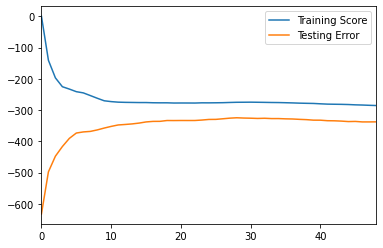

In [0]:
test_score = pd.Series(grid_search.cv_results_["mean_test_score"])
train_score = pd.Series(grid_search.cv_results_["mean_train_score"])
train_score.plot.line( label = "Training Score", legend =True)
test_score.plot.line(label = "Testing Error", legend = True)


For predicting star-rating:

In [0]:
for item in features:
  pipeline = make_pipeline(
      item[1],
      KNeighborsRegressor(n_neighbors = 20)
  )
  errs[str(item[0])] = get_cv_error(item[0], pipeline, "star-rating")
errs

['votes', 'director', 'cast']                            1.452213
['votes', 'year', 'description']                         1.110817
['votes', 'director']                                    1.199317
['year', 'description', 'director', 'cast', 'rating']    1.349975
['cast']                                                 1.733436
dtype: float64

In [0]:
pipelines = [
             make_pipeline(make_column_transformer(
              (StandardScaler(), ["votes","year"]),
              (TfidfVectorizer(norm = None, max_features = 100), "description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "euclidean")),
             make_pipeline(make_column_transformer(
              (StandardScaler(), ["votes","year"]),
              (TfidfVectorizer(norm = None, max_features = 100), "description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "manhattan")),
             make_pipeline(make_column_transformer(
              (StandardScaler(), ["votes","year"]),
              (TfidfVectorizer(norm = None, max_features = 100), "description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "minkowski")),
             make_pipeline(make_column_transformer(
              (Normalizer(), ["votes","year"]),
              (TfidfVectorizer(norm = None, max_features = 100), "description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "minkowski")),
             make_pipeline(make_column_transformer(
              (Normalizer(), ["votes","year"]),
              (TfidfVectorizer(norm = None, max_features = 100), "description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "euclidean")),
             make_pipeline(make_column_transformer(
              (Normalizer(), ["votes","year"]),
              (TfidfVectorizer(norm = None, max_features = 100), "description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "manhattan")),
             make_pipeline(make_column_transformer(
              (MinMaxScaler(), ["votes","year"]),
              (TfidfVectorizer(norm = None, max_features = 100), "description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "minkowski")),
             make_pipeline(make_column_transformer(
              (MinMaxScaler(), ["votes","year"]),
              (TfidfVectorizer(norm = None, max_features = 100), "description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "euclidean")),
             make_pipeline(make_column_transformer(
              (MinMaxScaler(), ["votes","year"]),
              (TfidfVectorizer(norm = None, max_features = 100), "description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "manhattan"))
             ]
best_combos = pd.Series()
index = 0
for pipeline in pipelines:
  best_combos[str(index)] = get_cv_error(["votes","year","description"] ,pipeline ,"star-rating")
  index += 1
best_combos

0    1.110817
1    1.107499
2    1.110817
3    1.219858
4    1.219858
5    1.194519
6    1.215897
7    1.215897
8    1.174526
dtype: float64

In [0]:
from sklearn.model_selection import GridSearchCV

X_train = df_no_na[["votes","year","description"]]
y_train = df_no_na["star-rating"]

pipeline =  make_pipeline(make_column_transformer(
              (StandardScaler(), ["votes","year"]),
              (TfidfVectorizer(norm = None, max_features = 100), "description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "manhattan"))

grid_search = GridSearchCV(
    pipeline,
    param_grid={"kneighborsregressor__n_neighbors": range(1, 50)},
    scoring="neg_mean_squared_error",
    return_train_score = True,
    cv=10
)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'kneighborsregressor__n_neighbors': 10}

In [0]:
pipeline =   make_pipeline(make_column_transformer(
              (StandardScaler(), ["votes", "year"]),
              (TfidfVectorizer(norm = None, max_features = 100),"description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 10, metric = "euclidean"))
get_cv_error(["votes", "year", "description"], pipeline, "star-rating")

1.0646479445815125

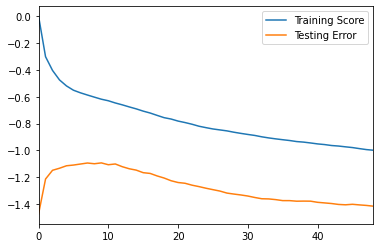

In [0]:
test_score = pd.Series(grid_search.cv_results_["mean_test_score"])
train_score = pd.Series(grid_search.cv_results_["mean_train_score"])
train_score.plot.line(label = "Training Score", legend = True)
test_score.plot.line(label = "Testing Error", legend = True)

In K-Nearest we see that we have different feature sets for metascore and star-rating. The feature set that we should use for metascore was based off of the votes and description that a movie has. Whereas the star-rating followed the set of features that linear regression had.  

KNearest does not outperform the linear regression model in either case, but is relatively close to the same performance of it. The best RMSEs were 18.015(metascore) and 1.064(star-rating). 

I believe the lack in performance of this model could be because of the grouping of the data being very clustered, where a lot of good movies were near each other and a lot of the bad and mediocre movies were grouped near each other.

### Lasso Regression

We chose Lasso as our last individual model, while it is still a linear model we chose it as it uses a method of shrinking the value to a central point like the mean to make a prediction.  

For predicting metascore:

In [0]:

errs = pd.Series()
for item in features:
  pipeline = make_pipeline(
      item[1],
      Lasso()
  )
  errs[str(item[0])] = get_cv_error(item[0], pipeline, "metascore")
errs

['votes', 'director', 'cast']                            22.650442
['votes', 'year', 'description']                         15.215518
['votes', 'director']                                    22.671416
['year', 'description', 'director', 'cast', 'rating']    19.118769
['cast']                                                 26.833931
dtype: float64

In [0]:
X_train = df_no_na[["votes", "year", "description"]]
y_train = df_no_na["metascore"]
lasso_params = {'lasso__alpha': np.arange(1, 5, 0.1)}


pipeline =   make_pipeline(
    ct_2, Lasso())

grid_search = GridSearchCV(
    pipeline,
    param_grid=lasso_params,
    scoring="neg_mean_squared_error",
    return_train_score = True,
    cv=10
)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'lasso__alpha': 1.4000000000000004}

In [0]:
pipeline =   make_pipeline(ct_2, Lasso(alpha= 1.4))
get_cv_error(["votes", "year", "description"], pipeline, "metascore")

15.157928650158905

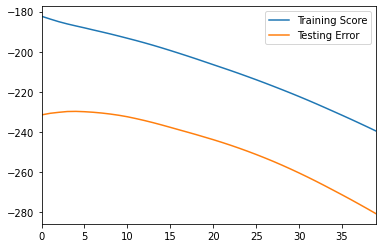

In [0]:
test_score = pd.Series(grid_search.cv_results_["mean_test_score"])
train_score = pd.Series(grid_search.cv_results_["mean_train_score"])
train_score.plot.line(label = "Training Score", legend = True)
test_score.plot.line(label = "Testing Error", legend = True)

For predicting star-rating

In [0]:

errs = pd.Series()
for item in features:
  pipeline = make_pipeline(
      item[1],
      Lasso()
  )
  errs[str(item[0])] = get_cv_error(item[0], pipeline, "star-rating")
errs

['votes', 'director', 'cast']                            1.869855
['votes', 'year', 'description']                         1.588054
['votes', 'director']                                    1.869855
['year', 'description', 'director', 'cast', 'rating']    1.588054
['cast']                                                 1.931059
dtype: float64

In [0]:
X_train = df_no_na[["votes", "year", "description"]]
y_train = df_no_na["star-rating"]
lasso_params = {'lasso__alpha':np.arange(1, 5, 0.1)}

pipeline =   make_pipeline(ct_2, Lasso())

grid_search = GridSearchCV(
    pipeline,
    param_grid=lasso_params,
    scoring="neg_mean_squared_error",
    return_train_score = True,
    cv=10
)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'lasso__alpha': 1.0}

In [0]:
pipeline =   make_pipeline(ct_2, Lasso(alpha= 1))
get_cv_error(["votes", "year", "description"], pipeline, "star-rating")

1.5880539611204736

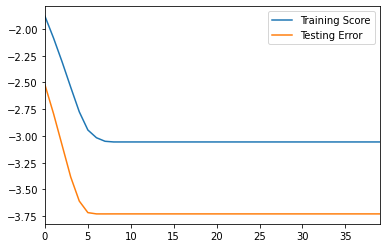

In [0]:
test_score = pd.Series(grid_search.cv_results_["mean_test_score"])
train_score = pd.Series(grid_search.cv_results_["mean_train_score"])
train_score.plot.line(label = "Training Score", legend = True)
test_score.plot.line(label = "Testing Error", legend = True)

In the Lasso regressor, the best feature sets to choose are the same as Linear Regression. However, the performance of each variable either do better than Linear or worse than Linear and KNearest.

In the case of metascore, it does better than all previous models scoring around 15.215. In the case of star-rating, we see a performance drop with its best RMSE being 1.588.

### Stacking Regressor

Now we want to combine the best score to see if we get a better score out by using a Stacking Regressor. To choose what went in to this model, we chose the top two scoring models and put them into the stacking regressor and made the final estimator the estimator that scored lower.

For predicting metascore, we chose the Linear model and the lasso model with Lasso being the final estimator.

In [0]:
X_train = df_no_na[["votes", "year", "description"]]
y_train = df_no_na["metascore"]
metascore_stacking = StackingRegressor(
    [("linear", make_pipeline(make_column_transformer(
    (StandardScaler(), ["votes", "year"]),
    (TfidfVectorizer(norm = None, max_features = 100), "description"),
    remainder = "drop"
), LinearRegression())),
("lasso", make_pipeline(make_column_transformer(
    (StandardScaler(), ["votes","year"]),
    (TfidfVectorizer(norm = None, max_features = 100), "description"),
    remainder = "drop"
), Lasso(alpha = 1.4)))], final_estimator = Lasso(alpha = 1.4))
np.sqrt(-cross_val_score(metascore_stacking, X=X_train, y=y_train, cv=5,
                 scoring="neg_mean_squared_error").mean())

16.040698393071896

For predicting star-rating, we chose K-Nearest and Linear Regression with Linear Regression being the final estimator.

In [0]:
y_train = df_no_na["star-rating"]
star_rating_stacking = StackingRegressor(
    [("knearest", make_pipeline(make_column_transformer(
              (StandardScaler(), ["votes","year"]),
              (TfidfVectorizer(norm = None, max_features = 100), "description"),
              sparse_threshold = 0,
              remainder = "drop"
              ), KNeighborsRegressor(n_neighbors = 20, metric = "manhattan"))),
     ("linear", make_pipeline(make_column_transformer(
    (StandardScaler(), ["votes","year"]),
    (TfidfVectorizer(norm = None, max_features = 100), "description"),
    remainder = "drop"
), LinearRegression()))
     ], final_estimator = LinearRegression())
np.sqrt(-cross_val_score(star_rating_stacking, X=X_train, y=y_train, cv=5,
                 scoring="neg_mean_squared_error").mean())

1.2858672168908876

In both cases, the result was either worse than it was before combining or in the middle of the two models, which was not what were hoping for.

### Best Model Predicting

Movie: The Greatest Showman

In [0]:
linear = make_pipeline(make_column_transformer(
    (StandardScaler(), ["votes","year"]),
    (TfidfVectorizer(norm = None, max_features = 100), "description"),
    remainder = "drop"
), LinearRegression())
df_greatest = pd.DataFrame([[215597, 2017, "Celebrates the birth of show business and tells of a visionary who rose from nothing to create a spectacle that became a worldwide sensation. "]], columns = ["votes", "year", "description"])
df_greatest

,votes,year,description
0,215597,2017,Celebrates the birth of show business and tell...


In [0]:
linear.fit(X = X_train, y = df_no_na[["star-rating"]])
linear.predict(X = df_test[["votes", "year", "description"]])


array([[6.2655347]])

The model predicts that the movie would have a star-rating of 6.26, when in reality it has a rating of 7.6.

In [0]:
y_train = df_no_na["metascore"]
lasso = make_pipeline(make_column_transformer(
    (StandardScaler(), ["votes","year"]),
    (TfidfVectorizer(norm = None, max_features = 100), "description"),
    remainder = "drop"
), Lasso(alpha = 1.4))

In [0]:
lasso.fit(X = X_train, y = y_train)
lasso.predict(X = df_test[["votes", "year", "description"]])

array([49.17651939])

The model does a little bit better with a predicting the metascore as its predicted metascore is 49.176, but its actual metascore is 48. 

# Summary

##Best Feature Sets:
  Linear Regression(metascore): [votes, year, description]</br>
  Linear Regression(star-rating): [votes, year, description] </br>
  KNearest(metascore): [votes, year]</br>
  KNearest(star-rating): [votes, year, description]</br>
  Lasso(metascore): [votes, year, description]</br>
  Lasso(star-rating): [votes, year, description]</br>

## RMSE Scores
Linear Regression(metascore): 16.972</br>
  Linear Regression(star-rating): 0.827 </br>
  KNearest(metascore): 18.015</br>
  KNearest(star-rating): 1.064</br>
  Lasso(metascore): 15.215</br>
  Lasso(star-rating): 1.588</br>
  Stacking(metascore): 16.041</br>
  Stacking(star-rating): 1.286</br>

In conclusion, the Lasso model was the best predictor for metascore and the Linear regression model was the best predictor for star-rating. 